In [1]:
from glob import glob
import numpy as np
import scipy as sp
import json
import os
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

os.chdir("../")

from src.detectors import gcc_phat_detector
from src.tdoa_matrix_to_tdoa_vector import tdoa_matrix_to_tdoa_vector

# Config

In [2]:
dataset_name = "tdoa_20201016"
experiment_name = "music_0015"


# Setup

In [3]:
dataset_folder = "./data/" + dataset_name + "/data/"

# Paths -----------------------
# Given relative to base of direcotry
input_folder = "./data/" + dataset_name + "/data/" + experiment_name + "/"
output_folder = "./results/" + dataset_name + "/data/" + experiment_name + "/"

# create output folder if it doesn't exist
Path(output_folder).mkdir(parents=True, exist_ok=True)


# Sound -> Detections

In [4]:
gcc_phat_detector(input_folder, output_folder=output_folder,
                  window_length=10000, speed_of_movement=1)
detections = np.load(output_folder + "detections.npy")
n_detection_windows = detections.shape[0]
n_mics = detections.shape[1]


# Detections -> tdoa-vector

In [5]:
tdoa_matrix_to_tdoa_vector(
    output_folder, output_folder=output_folder, cutoff_fraction_of_all_measuremnets=1/2)
tdoav = np.load(output_folder + "tdoa_vectors.npy")
df = pd.DataFrame(tdoav)
df.to_csv(output_folder + "tdoa_vectors_to_matlab.csv")


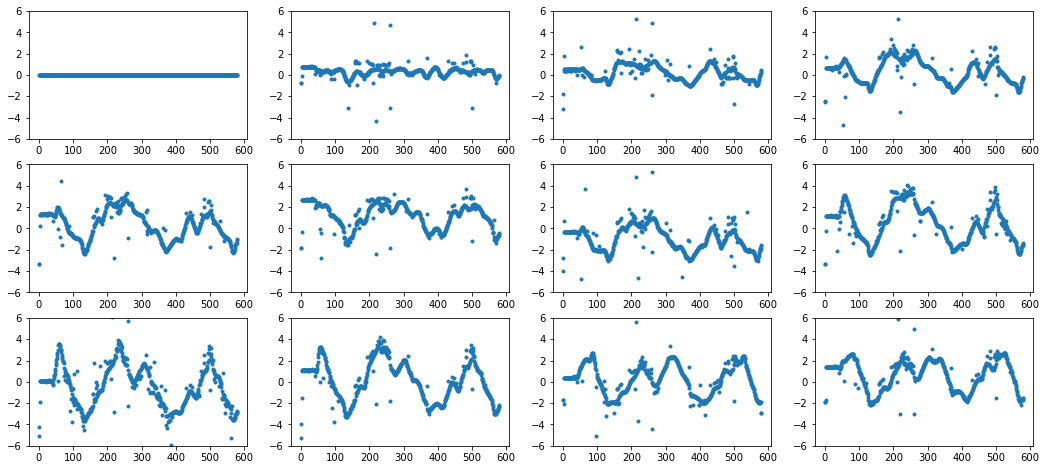

In [6]:
# Example plot
plt.subplots(nrows=3, ncols=4, figsize=(18, 8))

for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.plot(tdoav[:, i], '.')
    plt.ylim([-6, 6])


# tdoa-vector -> positions

In [8]:

matlab = "/Applications/MATLAB_R2022a.app/bin/matlab -nodesktop -nosplash -nodisplay -r "

os.system(matlab + "\"addpath('./matlab/matlab');tdoa_for_python('" +
          output_folder + "');exit\"")



                            < M A T L A B (R) >
                  Copyright 1984-2022 The MathWorks, Inc.
              R2022a Update 4 (9.12.0.2009381) 64-bit (maci64)
                                July 7, 2022

 
To get started, type doc.
For product information, visit www.mathworks.com.
 
inaccurate. RCOND =  1.459925e-16. 
> In tdoa_trilateration_y_one_bundle (line 49)
In misstdoa_reestimate_cols_rso (line 34)
In tdoa (line 62)
In tdoa_for_python (line 17)
 
inaccurate. RCOND =  7.268996e-17. 
> In tdoa_trilateration_y_one_bundle (line 49)
In misstdoa_reestimate_cols_rso (line 34)
In tdoa (line 62)
In tdoa_for_python (line 17)
 
inaccurate. RCOND =  1.042970e-16. 
> In tdoa_trilateration_y_one_bundle (line 49)
In misstdoa_reestimate_cols_rso (line 34)
In tdoa (line 62)
In tdoa_for_python (line 17)
 
inaccurate. RCOND =  6.150936e-17. 
> In tdoa_trilateration_y_one_bundle (line 49)
In misstdoa_reestimate_cols_rso (line 34)
In tdoa (line 62)
In tdoa_for_python (line 17)
 
inaccura

0

In [2]:
output_folder


NameError: name 'output_folder' is not defined